# Calibrating cameras in time 
This page provides code to calibrate video from the two cameras using the flashing light that is attached to the rig.

In [1]:
### Setting up workspace
#pip install opencv-python
import cv2
import numpy as np
import os
import datetime 
from datetime import timedelta
import pandas as pd
import random
import glob
import re
from csv import DictWriter

## Video details 

In [72]:
### Add file path to videos 
left_path=os.path.abspath('Add_file_path_to_left_video')
right_path=os.path.abspath('Add_file_path_to_right_video') 

video_name='Add_video_name'


In [73]:
### Read in videos 
left_video = cv2.VideoCapture(left_path)
right_video = cv2.VideoCapture(right_path)
video_height=1080

## Temporal alignment of two cameras using flashing light and real time clock
For this manual alignment a subset of frames will be saved to two folders (left & right) on your computer. A window pops up allowing the user to scroll through the images to identify the offset.

### User info needed

In [74]:
# number of seconds to segement video - should be wide enough to emcompass flashing light overlap between left and right without saving too many frames
# This will depend on how many seconds apart the two cameras were turned on and whether the time is correct on the real time clocks. 
frame_window = 10

# Folders to save frames too 
left_images = os.path.abspath('Add_file_path_to_left_image_folder') 
right_images=os.path.abspath('Add_file_path_to_left_image_folder')

### Run below code

In [75]:
### Extract video metadata (e.g. number frames, duration)
left_frame_count = int(left_video. get(cv2. CAP_PROP_FRAME_COUNT))
right_frame_count = int(right_video. get(cv2. CAP_PROP_FRAME_COUNT))

left_fps = left_video. get(cv2. CAP_PROP_FPS) 
right_fps = right_video. get(cv2. CAP_PROP_FPS) 

#Calculate video duration in seconds
left_duration = left_frame_count/left_fps
right_duration = right_frame_count/right_fps

In [76]:
### Extracting time of day details from video file name

def extract_time_info(path):
    filename = os.path.split(path)
    filename = filename[1] #selecting file name only, [0] for folder name
    time=filename.split("_") #splits filename at every "-"
    time=time[4] #selects time info (still includes .mp4 extension)
    time=time.split(".") #removes .mp4 extension 
    time=time[0] #left with time in H-M-S-MS format
    time=time.split("-")
    hour = int(time[0]) #24 hour clock
    minute = int(time[1])
    second = int(time[2])
    microsecond = int(time[3])
    timeobject=datetime.time(hour, minute, second, microsecond)
    
    return(timeobject, hour, minute, second, microsecond)

left_timeobject, l_hour, l_minute, l_second, l_microsecond = extract_time_info(left_path)
right_timeobject, r_hour, r_minute, r_second, r_microsecond= extract_time_info(right_path)

In [77]:
### identify start time of frame 0 and difference in time from camera start
frame0_left=datetime.timedelta(hours=l_hour, minutes=l_minute, seconds=l_second, microseconds=l_microsecond)
frame0_right=datetime.timedelta(hours=r_hour, minutes=r_minute, seconds=r_second, microseconds=r_microsecond)

start_difference=abs(frame0_left-frame0_right)
start_difference=start_difference.total_seconds()


In [78]:
### Segment video frames that were capture within 3s of each other to reduce video size, and capture flashing light.
### Flashing light every 1s. 
def segment_video():
#3s start_difference second sample window will be selected - ensures overlap in videos and flashes (occurring every 1s)
    sample_window = int(frame_window +start_difference) 

# Select a random video sample to work with 
    random_video_section=int(left_duration/sample_window)# split full video time into sections
    random_video_section=random_video_section-1 #remove last option 
    random_video_section=random.randint(1,random_video_section)

    video_start=random_video_section*sample_window #video start time in seconds
    video_end= video_start+sample_window # video end time in seconds 

# Calculate section frame numbers
    start_frame = int(video_start*left_fps) #doesn't matter whether use left or right - both values should be same 
    end_frame = int(video_end*left_fps)
    return(start_frame, end_frame)


In [79]:
### Save frame subset to relevant folder   
def save_frames_to_folder(image_path, video_name):
    
    files = glob.glob(image_path+"/*")
    if len(files)>0:
        for f in files:
            os.remove(f)
    
    current = start_frame
    while current <=end_frame:
        video_name.set(1,current)
        ret, frame = video_name.read()
        cv2.imwrite(image_path+f'/Frame_{current}.jpg', frame)
        current=current+1
    else:
      print("Finished saving frames") 


## Go through frame subsets to calculate offset 
Use below code to match frames and save offset to csv. 

In [80]:
### Scroll through left and right frames to calculate offset 

def manual_offset(left_images, right_images, file):

    l_images_list=glob.glob(left_images+"/*")
    r_images_list=glob.glob(right_images+"/*")
    
    l_images_list = sorted(l_images_list)
    r_images_list = sorted(r_images_list)

    index_l = 0
    index_r=0
    l_frame=[]
    r_frame=[] 
    while(True):
            l_frame = l_images_list[index_l]
            l_frame=l_frame.split("/")
            l=len(l_frame)-1
            l_frame= (l_frame[l])
            r_frame = r_images_list[index_r]
            r_frame=r_frame.split("/")
            r=len(r_frame)-1
            r_frame= (r_frame[r])
            img_l = cv2.imread(l_images_list[index_l], 1)
            img_r = cv2.imread(r_images_list[index_r], 1)
            font = cv2.FONT_HERSHEY_SIMPLEX
            img_l = cv2.putText(img_l, l_frame, (10,video_height-40), font, 2, (0, 255, 0), 2, cv2.LINE_AA)
            img_r = cv2.putText(img_r, r_frame, (10,video_height-40), font, 2, (0, 255, 0), 2, cv2.LINE_AA)
            stack = np.hstack((img_l, img_r))
            cv2.imshow(f'current image', stack)
            key = cv2.waitKey(0)

            if key == ord('1'):
                index_l -=1
                l_frame=[]
            if key == ord('2'):
                index_l+=1
                l_frame=[]
            if key == ord('9'):
                index_r -=1
                r_frame=[]
            if key == ord('0'):
                index_r+=1 
                r_frame=[]

            if key ==ord('s'):
                l_frame = l_images_list[index_l]
                l_frame=l_frame.split("/")
                l=len(l_frame)-1
                l_frame= (l_frame[l]) 
                r_frame = r_images_list[index_r]
                r_frame=r_frame.split("/")
                r=len(r_frame)-1
                r_frame= (r_frame[r])
                break

            elif key == ord('q'):
                l_frame=[]
                r_frame=[]
                break

            cv2.destroyAllWindows()
    if len(l_frame) > 0:
        l_frame_no=re.findall(r'\d+', l_frame)
        r_frame_no=re.findall(r'\d+', r_frame)
        offset = int(l_frame_no[0])- int(r_frame_no[0])

        print("Left frame number =",  l_frame_no[0])
        print("Right frame number =", r_frame_no[0]) 
        print("Offset =" ,offset)

        first = []
        if l_frame_no[0] >= r_frame_no[0]:
            first = "Left"
            print("Left camera started first with an offset of", offset)

        if r_frame_no[0] >= l_frame_no[0]:
            first = "Right"
            print("Right camera started first with an offset of", abs(offset))

        left_name=left_path.split("/")
        x=len(left_name)
        x=x-1
        left_name=left_name[x]

        right_name=right_path.split("/")
        x=len(right_name)
        x=x-1
        right_name=right_name[x]

        field_names = ['Video_name', 'Left_video_name', 'Right_video_name', 'Left_Frame','Right_Frame', 'Offset', "First"]
        dict = {'Video_name':video_name,'Left_video_name': left_name, 'Right_video_name': right_name, 'Left_Frame': l_frame_no[0],
                'Right_Frame': r_frame_no[0], 'Offset': abs(offset), "First":first}

        with open(file, 'a') as f_object:
            dictwriter_object = DictWriter(f_object, fieldnames=field_names)
            dictwriter_object.writerow(dict)
            f_object.close()
    if len(l_frame) == 0:
        print("Exited without saving an offset")
        

#### Scroll through left images and right images until frames matched on each side 

2 = move left frames forward 

1 = move left frames back

0 = move right frames forward 

9 = more right frames back 

s = save frame numbers to calculate offset 

Offset will be automatically saved to csv file 

In [81]:
### Add folder path for left and right images, and file path for csv where need offset saving to 
start_frame, end_frame=segment_video()
save_frames_to_folder(left_images,left_video)
save_frames_to_folder(right_images,right_video)   
manual_offset(left_images, right_images, 'File_path_to_csv_where_temporal_offset_should_be_saved')

## If you can't find match select another sample of video to try and re-run. If still not matched increase the sample window (e.g. from 3s to 4s). 


Finished saving frames
Finished saving frames
Left frame number = 43218
Right frame number = 43332
Offset = -114
Right camera started first with an offset of 114


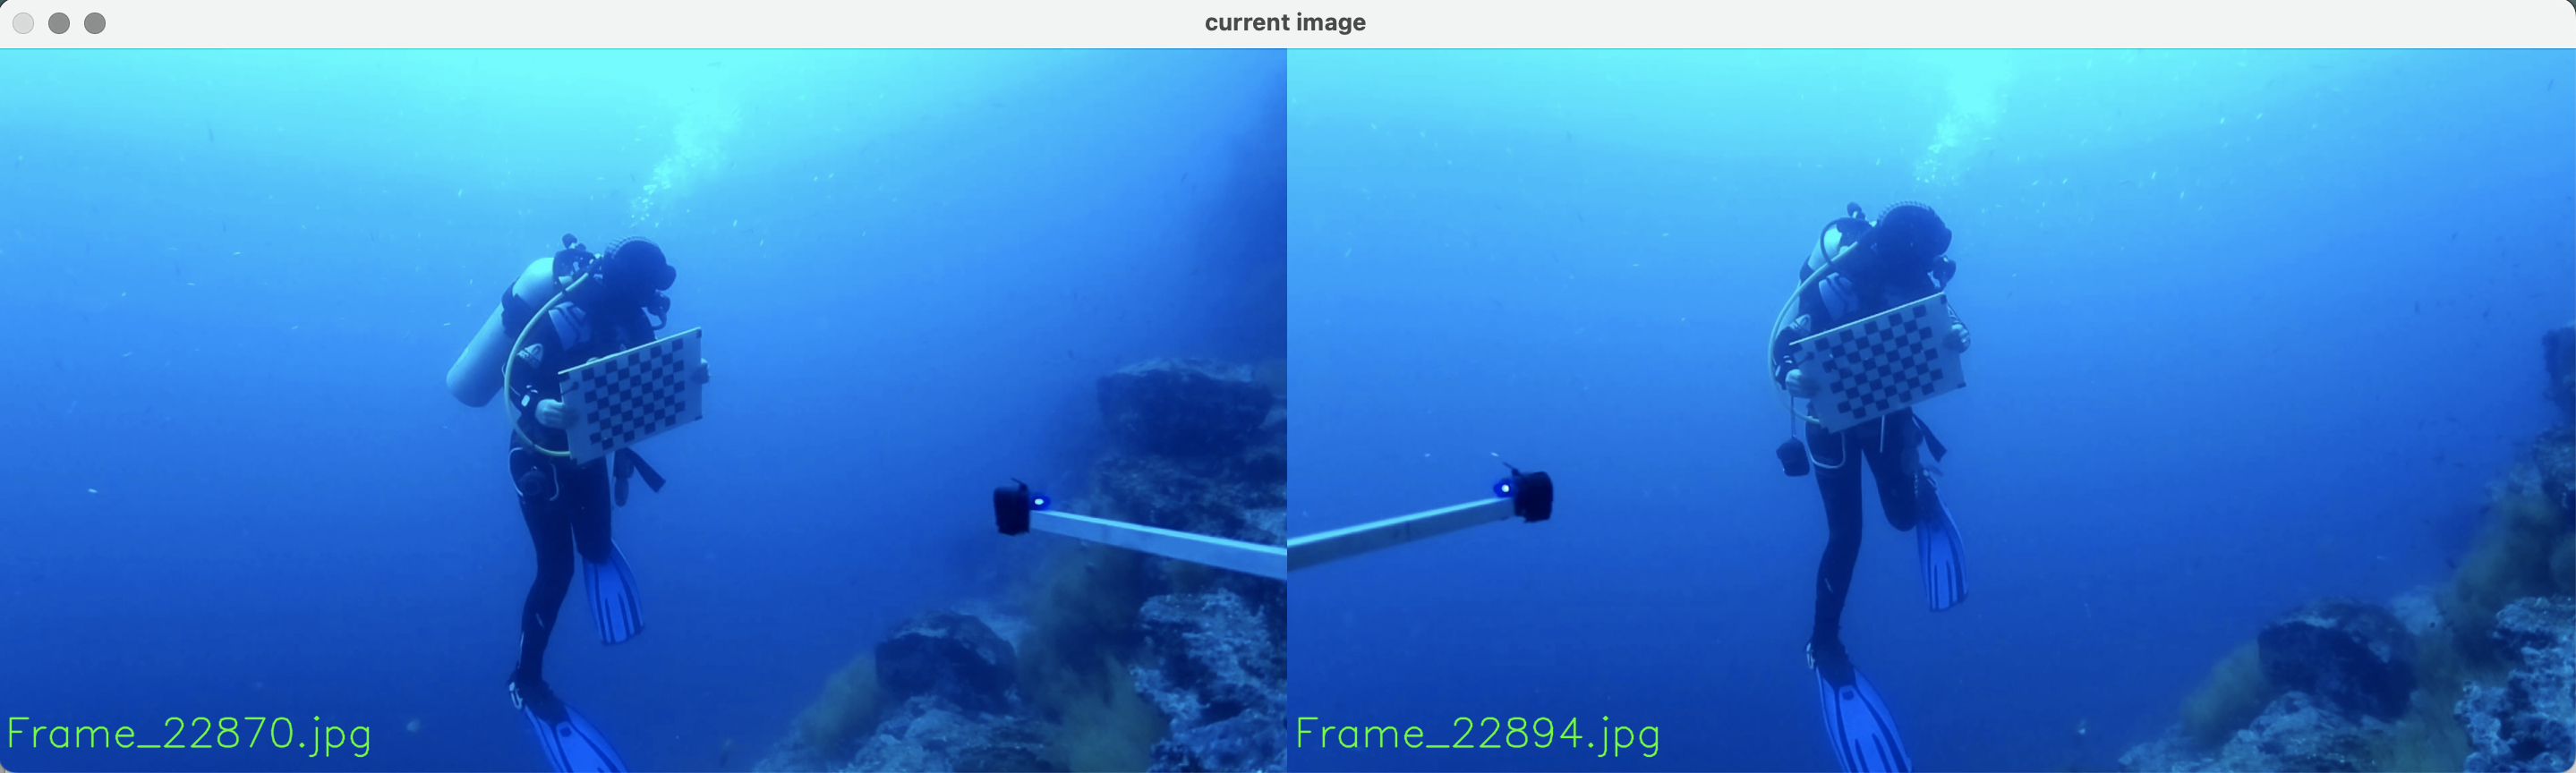